In [1]:
import ztfimg
from ztfimg import catalog as catalog
import ztfin2p3
from ztfin2p3 import catalog
import pandas
import numpy as np
import jax
import optax
import jax.numpy as jnp
from jax.scipy import stats as jstats
import matplotlib.pyplot as plt

In [2]:
import pkg_resources
print(pkg_resources.get_distribution('jax').version)

0.4.26


In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


# Image selection

In [4]:
# importing image
img = ztfimg.ScienceQuadrant.from_filename("/sps/ztf/data/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits")
q1 = img.get_ccd().get_quadrant(1) #selects quadrant 1 
qimg1 = q1.get_data() #converted to numpy array

# importing data into a pandas.dataframe
qimg1_catalog = ztfin2p3.catalog.get_img_refcatalog(q1, which="gaia_dr2") # selects the data corresponding to the quadrant in the gaia_dr2 catalog
qimg1_catalog['isolated'] = ztfimg.catalog.get_isolated(qimg1_catalog, seplimit=20) #select stars that are 15 arcsec apart and add a Boolean column
qimg_catalog_isolated = qimg1_catalog.loc[qimg1_catalog['isolated'] == True] # we keep only isolated stars (whose Boolean is True)

# magnitude selection
mag_inf = qimg_catalog_isolated.phot_g_mean_mag > 14 #selects magnitudes above 14
mag_sup = qimg_catalog_isolated.phot_g_mean_mag < 18 #selects magnitudes below 18
qimg_catalog_isolated_mag = qimg_catalog_isolated.loc[mag_inf & mag_sup] #application of the mask on magnitudes
qimg_catalog_isolated_mag = qimg_catalog_isolated_mag.drop('isolated', axis=1) #supression of isolated column

# location selection
mag_bord_left = qimg_catalog_isolated_mag.x > 15 # removes stars on the left edge of 15 pixels
mag_bord_right = qimg_catalog_isolated_mag.x < (q1.shape[0]-15) # removes stars on the right edge of 15 pixels
mag_bord_top = qimg_catalog_isolated_mag.y > 15 # removes the stars on the top edge by 15 pixels
mag_bord_bottom = qimg_catalog_isolated_mag.y < (q1.shape[1]-15) # removes stars on the bottom edge of 15 pixels
mag_bord_combined = np.logical_and.reduce((mag_bord_left, mag_bord_right, mag_bord_top, mag_bord_bottom)) #edge selection
qimg_catalog_isolated_mag_bord = qimg_catalog_isolated_mag[mag_bord_combined] #application of edge mask
#qimg_catalog_isolated_mag_bord.to_csv('data_ztf.csv', index=False) #to save the dataframe in csv format
qimg_catalog_isolated_mag_bord

id  coord_ra  coord_dec  phot_g_mean_flux  \
3292   220210914664501376  1.026161   0.637330      3.411760e+05   
3314   220210949024241920  1.025702   0.637414      2.846405e+05   
3343   220214655577103232  1.022990   0.637796      6.637216e+05   
3494   220216407923781760  1.023645   0.639737      3.310731e+05   
3524   220213216767321088  1.026577   0.638661      7.455134e+05   
...                   ...       ...        ...               ...   
45776  220167793192842368  1.033080   0.634488      4.161678e+06   
45799  220175077457571712  1.036926   0.636100      1.675470e+06   
45891  220225586272711168  1.030969   0.639192      6.834436e+05   
45903  220222596975471872  1.031456   0.639021      6.083751e+05   
46083  220222047219645952  1.032855   0.639023      4.561568e+05   

       phot_bp_mean_flux  phot_rp_mean_flux  phot_g_mean_fluxErr  \
3292        2.496884e+05       4.863944e+05           333.605022   
3314        1.552300e+05       4.988820e+05           263.706599   
3343        4.199027e+05       1.086072e+06           553.114736   
3494        2.083656e+05       5.224247e+05           297.967950   
3524        4.821637e+05       1.142259e+06           524.353589   
...                  ...                ...                  ...   
45776       3.407272e+06       5.055197e+06          1242.641362   
45799       1.183528e+06       2.416099e+06           681.649828   
45891       4.806962e+05       9.924018e+05           407.310306   
45903       5.244016e+05       7.197826e+05           425.536839   
46083       3.466966e+05       6.176064e+05           319.226787   

       phot_bp_mean_fluxErr  phot_rp_mean_fluxErr  coord_raErr  ...  \
3292            4307.633356           1871.193552     0.002145  ...   
3314            2006.851979           3996.709121     0.001880  ...   
3343            1744.992099           2613.982357     0.001542  ...   
3494            1487.596690           3983.500840     0.001617  ...   
3524            3058.071864           5102.794374     0.001253  ...   
...                     ...                   ...          ...  ...   
45776           5762.443728           7624.821103     0.000454  ...   
45799           2936.846731           3462.371170     0.000738  ...   
45891           1946.126256           4175.423717     0.001170  ...   
45903           2348.414058           4584.703300     0.001287  ...   
46083           1693.682760           1940.580623     0.001605  ...   

              ra        dec  phot_g_mean_mag  phot_bp_mean_mag  \
3292   58.794687  36.516333        17.567620         17.906570   
3314   58.768417  36.521120        17.764324         18.422627   
3343   58.612995  36.543040        16.845101         17.342194   
3494   58.650511  36.654212        17.600256         18.103001   
3524   58.818547  36.592557        16.718927         17.192079   
...          ...        ...              ...               ...   
45776  59.191138  36.353509        14.851894         15.069049   
45799  59.411462  36.445829        15.839724         16.217119   
45891  59.070190  36.622983        16.813309         17.195389   
45903  59.098059  36.613195        16.939637         17.100906   
46083  59.178221  36.613349        17.252280         17.550192   

       phot_rp_mean_mag  phot_g_mean_magErr  phot_bp_mean_magErr  \
3292          17.182594            0.001062             0.018731   
3314          17.155071            0.001006             0.014037   
3343          16.310420            0.000905             0.004512   
3494          17.105006            0.000977             0.007751   
3524          16.255654            0.000764             0.006886   
...                 ...                 ...                  ...   
45776         14.640720            0.000324             0.001836   
45799         15.442279            0.000442             0.002694   
45891         16.408347            0.000647             0.004396   
45903         16.757062            0.000759             0.00486

# Functions

The probability density function for multivariate_normal is:
$$
f(x) = \frac{1}{\sqrt{2\pi \det(\Sigma)}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right)
$$

In [5]:
def get_stamps(dataframe, size=17):
    """
    Parameters:
    ----------
    dataframe: pandas.dataframe
        dataframe of stars's data from Gaia dr2
    size: int
        stamp size (17,17)

    Returns:
    --------
    stamps: np.asarray
        data of the star image
    """
    stamps = []
    for index, df in qimg_catalog_isolated_mag_bord.iterrows():
        x0 = int(round(df["x"]))
        y0 = int(round(df["y"]))
        left = x0 - (size // 2)
        top = y0 - (size // 2)
        right = left + size
        bottom = top + size
        stamps.append(qimg1[top:bottom, left:right])
    return np.asarray(stamps)

def get_model(params):
    """
    returns the normalized Gaussian function
    =>
    Parameters:
    -----------
    params: pytree
        [mu: (2,N) centroids
         a: (N,) amplitudes
         b: (N,) backgrounbds
         pgrid: (N, size*size)
         sigmax: (1,) float
         sigmay: (1,) float
         ]
    Returns:
    -------
    model : arraylike
        the normalized Gaussian function
    """
    mu, a, b, sigmax, sigmay = params
    
    cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
    norm = jstats.multivariate_normal.pdf(pos[None,:],  # same structure for all stars
                                      mean = mu[:,None], # one position per star
                                      cov = cov[None,:] # same cov for all stars
                                     )
    norm_model =  a[:,None]*norm + b[:,None] # (N, size*size)
    return norm_model


def get_likelihood(params):
    """
    Computes the Chi squared from selected model 
    
    Parameters:
    ----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    --------
    summ: float
        chi squared
    """
    model = get_model(params)
    summ = jnp.sum((model - data)**2)
    return summ

def get_logprior(params):
    """
    Returns the probability to have sigmax and sigma y
    
    Parameters:
    -----------
    params: list
        selected model parameters
    
    Returns:
    -------
    logprior: float
        sum of the two sigma probabilities
    """
    mu, a, b, sigmax, sigmay = params
    logprior_sx = jstats.norm.logpdf(sigmax, loc=1, scale=0.5) # float
    logprior_sy = jstats.norm.logpdf(sigmay, loc=1, scale=0.5) # float
    logprior = logprior_sx + logprior_sy # get the maximize
    return logprior

def get_logprob(params):
    """ 
    Computes the sum of the sigma probabilities and the chi squared
    
    Parameters:
    -----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    logprob: float
        sum of the sigma probabilities and the chi squared
    """
    logprior = -1* get_logprior(params) # to minimize
    likelihood = get_likelihood(params)
    logprob = logprior + likelihood
    return logprob

In [6]:
def fit_tncg(func, init_param, 
             niter=10, tol=5e-3, 
             lmbda=1e2, 
             **kwargs):
    """ Hessian-free second order optimization algorithm

    The following implementation of TN-CG is largely based on
    recommendations given in Martens, James (2010, Deep learning via
    Hessian-free optimization, Proc. International  Conference on
    Machine Learning).

    Parameters
    ----------
    func: function
        function to minimize. Should return a float.

    init_param: 
        entry parameter of the input func

    niter: int
        maximum number of iterations

    tol: float
        targeted func variations below which the iteration will stop

    lmbda: float
        lambda parameter of the tncg algorithm. (optstate)

    **kwargs other func entries 

    Returns
    -------
    list
        - best parameters
        - loss (array)

    Example
    -------
    ```python
    import jax
    from edris import simulation, minimize
    key = jax.random.PRNGKey(1234)
    truth, simu = simulation.get_simple_simulation(key, size=1_000)

    def get_total_chi2(param, data):
        # model for a line with error on both axes but no intrinsic scatter.
        x_model = param["x_model"]
        y_model = x_model * param["a"] + param["b"]
    
        chi2_y = jnp.sum( ((data["x_obs"] - x_model)/data["x_err"])**2 )
        chi2_x = jnp.sum( ((data["y_obs"] - y_model)/data["y_err"])**2 )
    
        return chi2_y + chi2_x

    init_param = {"a": 8., "b":0., "x_model": simu["x_obs"]} # careful, must be float
    best_params, loss = minimize.fit_tncg(get_total_chi2, init_param, data=simu)
    ```
    
    """
    # handle kwargs more easily
    func_ = lambda x: func(x, **kwargs)
    fg = jax.value_and_grad(func_)
    
    # - internal function --- #
    def hessian_vector_product(g, x, v):
        return jax.jvp(g, (x,), (v,))[1]

    def step_tncg(x, optstate):
        loss, grads = fg(x)
        lmbda = optstate['lmbda']
        fvp = lambda v: jax.tree_util.tree_map(lambda d1, d2: d1 + lmbda*d2, hessian_vector_product(jax.grad(func_), x, v), v)
        updates, _ = jax.scipy.sparse.linalg.cg(fvp, grads, maxiter=50)
        coco = jax.tree_util.tree_reduce(lambda x, y: x+y, jax.tree_util.tree_map(lambda x, y: (-x*y).sum(), grads, updates))
        return updates, loss, optstate, coco

    step_tncg = jax.jit( step_tncg )
    # ----------------------- #
    
    x = init_param
    optstate = {'lmbda': lmbda}
    losses = []

    for i in range(niter):
        updates, loss, optstate, coco = step_tncg(x, optstate)
        x1 = jax.tree_util.tree_map(lambda x, y: x - y, x, updates)
        dloss = func_(x1) - loss
        losses.append(loss)
        rho = dloss / coco
        
        if rho < 0.25:
            optstate['lmbda'] = optstate['lmbda'] * 1.5
        elif rho > 0.75:
            optstate['lmbda'] = optstate['lmbda'] * 0.3
            
        if dloss < 0: # accept the step
            x = x1
            
        if tol is not None and dloss > -tol:
            break
        
    return x, losses


def fit_adam(func, init_params,
             learning_rate=5e-3, niter=200, 
             tol=1e-3,
             **kwargs):
    """ simple Adam gradient descent using optax.adam

    Parameters
    ----------
    func: function
        function to minimize. Should return a float.

    learning_rate: float
        learning rate of the gradient descent.
        (careful, results can be sensitive to this parameter)
        
    init_param: 
        entry parameter of the input func

    niter: int
        maximum number of iterations

    tol: float
        targeted func variations below which the iteration will stop

    **kwargs other func entries 

    Returns
    -------
    list
        - best parameters
        - loss (array)        
    """
    # handle kwargs more easily
    func_ = lambda x: func(x, **kwargs)
    
    # Initialize the adam optimizer
    params = init_params
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    opt_state = optimizer.init(params)
    
    grad_func = jax.jit(jax.grad( func_ )) # get the derivative
    
    # and do the gradient descent
    losses = []
    for i in range(niter):
        current_grads = grad_func(params)
        updates, opt_state = optimizer.update(current_grads, opt_state)
        params = optax.apply_updates(params, updates)
        losses.append( func_(params) ) # store the loss function
        if tol is not None and (i>2 and ((losses[-2] - losses[-1]) < tol)):
            break
            
    return params, losses

In [7]:
stamps = get_stamps(qimg_catalog_isolated_mag_bord.head(6))
coefs = np.sum(stamps, axis=(1,2))
stamps/=coefs[:,None, None]

In [8]:
nstars = len(stamps)
size = 17
X = jnp.linspace(-size/2, size/2, size)
Y = jnp.linspace(-size/2, size/2, size)
X, Y = jnp.meshgrid(X, Y)
pos = jnp.vstack((X.ravel(), Y.ravel())).T

# guess
x0 = jnp.zeros((nstars,), dtype="float32")
y0 = jnp.zeros((nstars,), dtype="float32")
mu = jnp.vstack([x0,y0]).T
sigmax, sigmay = 1., 1.
cov = jnp.asarray(([sigmax**2 , 0] , [0, sigmay**2]), dtype="float32")
pgrid = jnp.zeros((nstars, size*size,), dtype="float32")
a = jnp.ones((nstars,), dtype="float32")
b = jnp.zeros((nstars,), dtype="float32")

data = stamps.reshape(len(stamps), -1)
grad_func = jax.jit(jax.grad(get_logprob)) # get the derivative

In [9]:
%%time
guess = [mu, a, b, sigmax, sigmay]
adam_params, adam_loss = fit_adam(get_logprob, guess, learning_rate=0.001, tol=1e-5, niter=5000)

CPU times: user 21min 8s, sys: 52.1 s, total: 22min
Wall time: 1min 34s


In [10]:
%%time
guess = [mu, a, b, sigmax, sigmay]
tncg_params, tncg_loss = fit_tncg(get_logprob, guess, tol=1e-5, niter=50, lmbda=500)

CPU times: user 2min 48s, sys: 6.9 s, total: 2min 55s
Wall time: 17.2 s


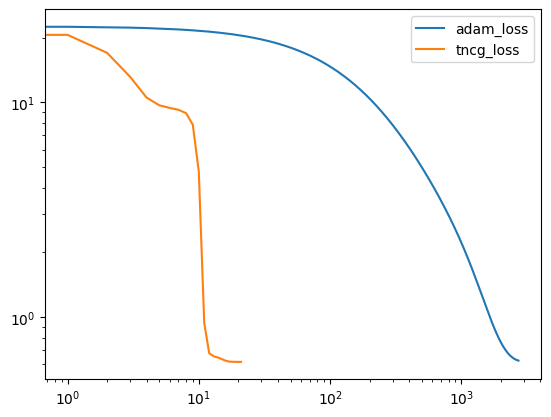

In [11]:
fig, ax = plt.subplots()
ax.plot(adam_loss, label='adam_loss')
ax.plot(tncg_loss, label='tncg_loss')
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

In [12]:
def plots(models, stamps):

    num_cols = 4
    num_rows = len(end)
    fig_height = num_rows * 6
    fig_width = num_cols * 6

    fig, axes = plt.subplots(num_rows, num_cols, figsize = (fig_width, fig_height))

    for i, (index, row) in enumerate(end.iterrows()):
        ax1 = axes[i,0]
        im1 = ax1.imshow(stamps[i].reshape(size,size))
        ax1.set_title('Real data')
        plt.colorbar(im1, ax=ax1, location = 'left', orientation = 'vertical', shrink=0.75, pad=0.07)
        ax2 = axes[i,1]
        im2 = ax2.imshow(models[i].reshape(size,size))
        ax2.set_title('Gaussian model')
        plt.colorbar(im2, ax=ax2, location = 'left', orientation = 'vertical', shrink=0.75, pad=0.07)
        ax3 = axes[i,2]
        im3 = ax3.imshow(stamps[i].reshape(size,size)- models[i].reshape(size,size))
        ax3.set_title('Residuals: real data - model')
        plt.colorbar(im3, ax=ax3, location = 'left', orientation = 'vertical', shrink=0.75, pad=0.07)
        ax4 = axes[i, 3]
        fig = plt.gcf()
        spec = ax4.get_subplotspec()
        fig.delaxes(ax4)
        ax4_3d = fig.add_subplot(spec, projection='3d')
        ax4_3d.plot_surface(X, Y, stamps[i].reshape(size,size), cmap='Reds', alpha=0.6, label='real data')
        ax4_3d.contour3D(X, Y, models[i].reshape(size,size), levels=50, cmap='Purples', alpha=0.6)
        ax4_3d.set_xlabel('x', fontdict=dict(weight='bold'))
        ax4_3d.set_ylabel('y', fontdict=dict(weight='bold'))
        ax4_3d.xaxis.set_tick_params(rotation=45)
        ax4_3d.yaxis.set_tick_params(rotation=-45)
        c1 = ax4_3d.contour(X, Y, models[i].reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='blue', alpha=0.5)
        c2 = ax4_3d.contour(X, Y, stamps[i].reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='red', alpha=0.5)
        ax4_3d.contour(X, Y, models[i].reshape(size, size), 8, zdir='x', offset=np.min(X), colors='blue', alpha=0.5)
        ax4_3d.contour(X, Y, stamps[i].reshape(size, size), 8, zdir='x', offset=np.min(X), colors='red', alpha=0.5)
        h1, _ = c1.legend_elements()
        h2, _ = c2.legend_elements()
        ax4_3d.legend([h1[0], h2[0]], ['Model', 'real data'], fontsize=13)
    
    plt.tight_layout()
    plt.show()

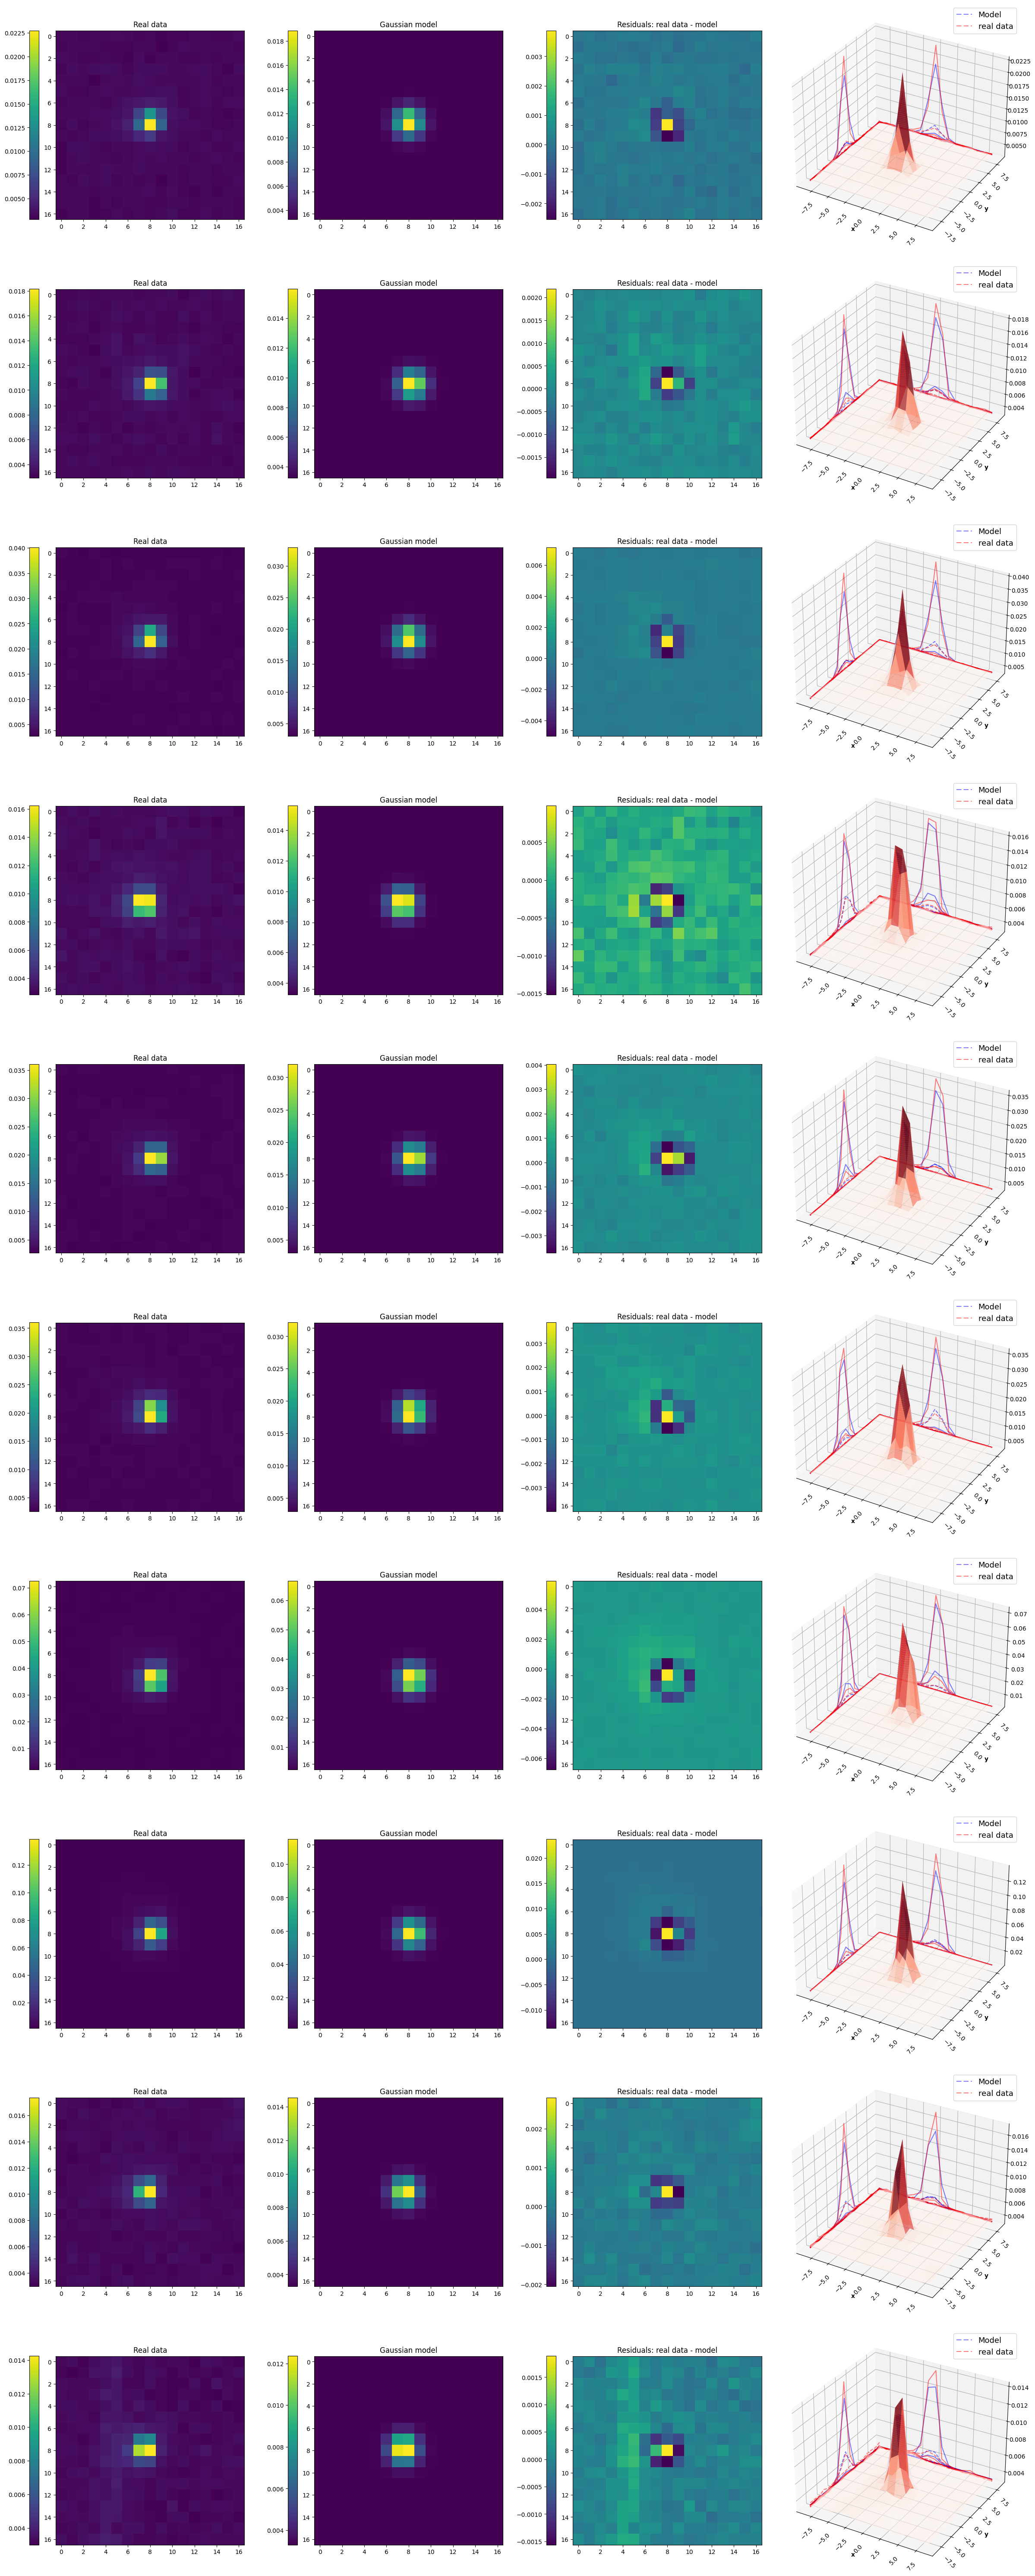

chi squared: 0.1083493


In [13]:
models = get_model(tncg_params)
total_images = 10
end = qimg_catalog_isolated_mag_bord.head(total_images)
plots(models, stamps)
print("chi squared:", get_likelihood(tncg_params))

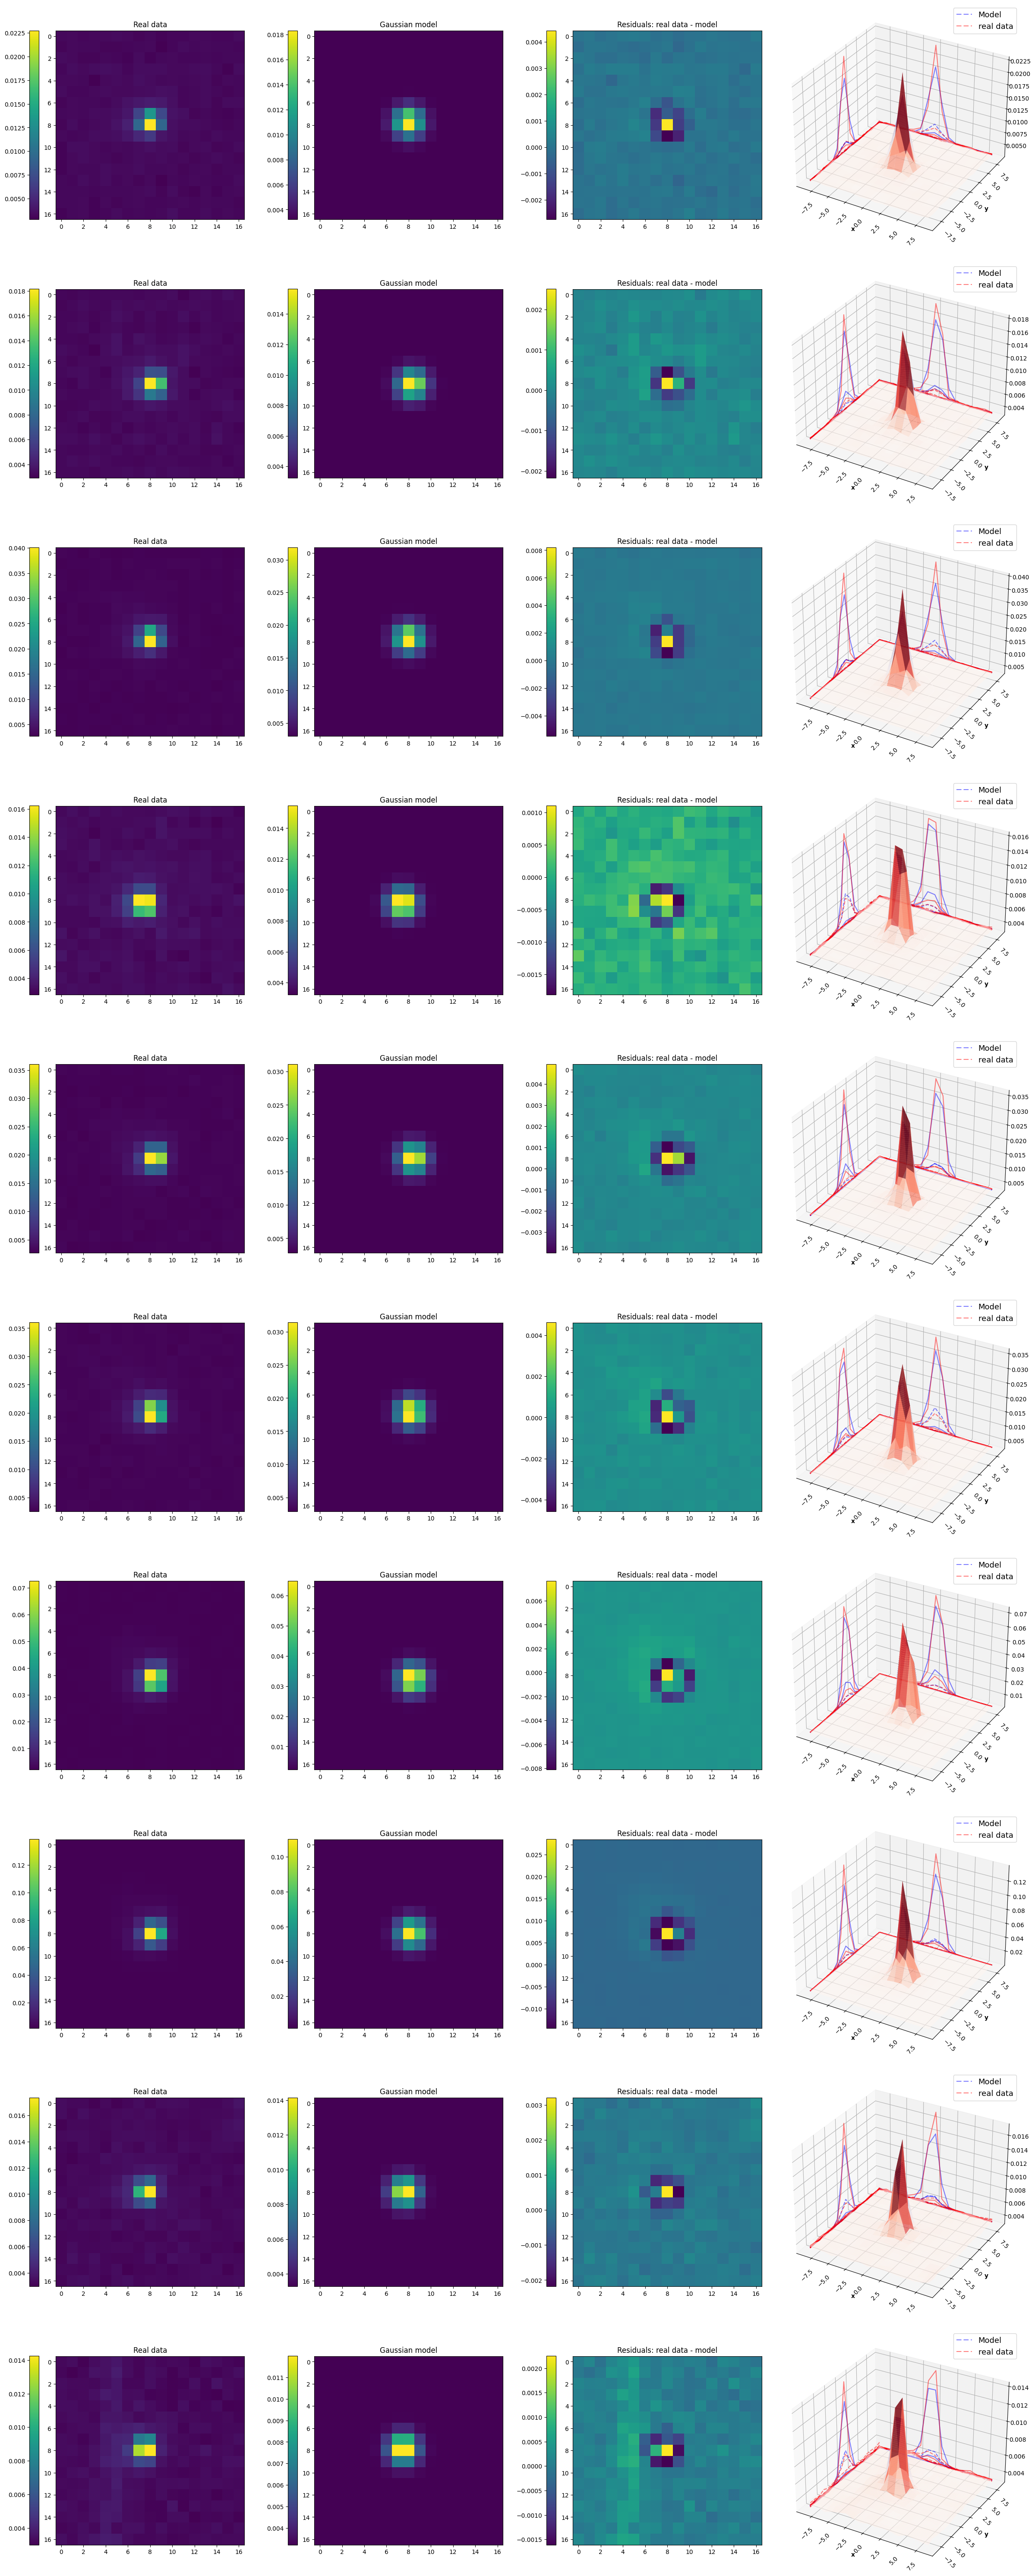

chi squared: 0.14706154


In [14]:
models = get_model(adam_params)
total_images = 10
end = qimg_catalog_isolated_mag_bord.head(total_images)
plots(models, stamps)
print("chi squared:", get_likelihood(adam_params))